If running the code on anything except the IBM Quantum Lab, uncomment the following cell to install the required packages

In [ ]:
# !pip install qiskit
# !pip install pylatexenc

If running the code on IBM Quantum Lab, start running the cells from here

In [1]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import pylatexenc

We define some constants required for defining the problem. Feel free to play around with the constants in the next cell to modify the model problem.

**The number of qubits should not exceed 6**
> Due to the current limitation of the number of qubits available to us, we constraint our problem to the use of only 7 qubits (6 qubits to make the req. spatial grid and 1 ancillary qubit). 6 qubits allow us to form 2^6=64 grid points. In the future as more qubits become available, we can easily scale our model to more complex simulation problems.

In [18]:
#Number of qubits
n=6

#Circuit 
phi=0.1 #time step
iterations=30 #iterations

#Potential
V=1.75 

#Spatial Grid
N=2**n #grid points
xMin=-4
xMax=4
x = np.linspace(xMin,xMax, num=N)

We now define a wavefunction which needs to simulated for our model problem. For simplicity, we consider a Gaussian wavefunction, however, more complex wavefunctions can also be simulated by simply modifying the following cell.

/opt/conda/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


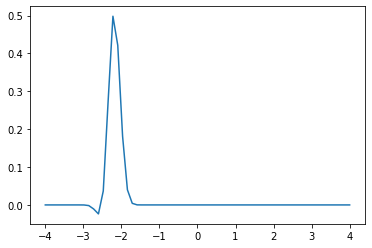

In [19]:
#Wavefunction
mu=-2.25
psi= (1/(np.sqrt(2*np.pi)*2*0.4)*np.exp(-(0.5*(x-mu)**2)/(2*0.016)))*np.exp(-300j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))
plt.plot(x,psi)

Next, we define the quantum well (potential barrier) in our model. The position of this quantum well is determined by the gates we apply the potential propagator to. In this model, we apply exp(i * V * phi) to a qubit, and hence use a phase gate parameterized by the value V * phi. The Potential and momentum operators are defined using the Split Operator Fourier Transform Algorithm. The first qubit in the circuit is defined as the ancillary qubit. Finally, we code a single time step of the split operator algorithm using all the propagators we defined before.

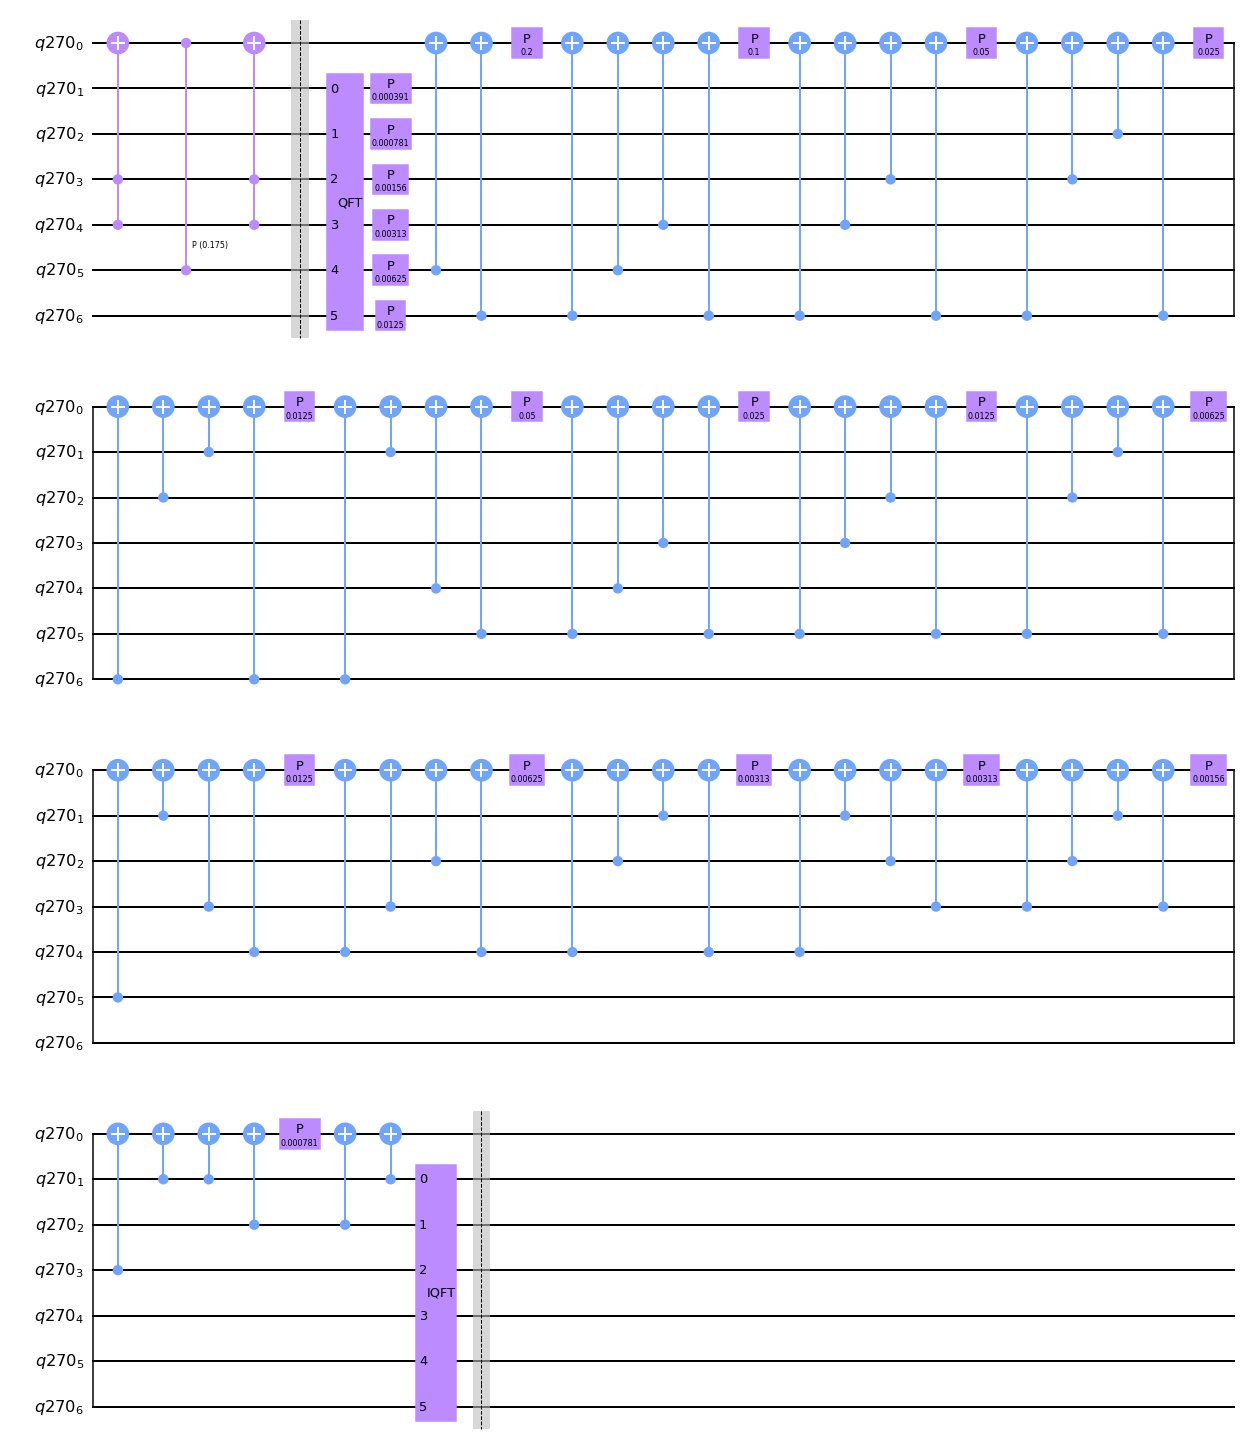

In [20]:
qubits=QuantumRegister(n+1)
splitOp=QuantumCircuit(qubits,name="splitOp")
'''potential operator''' 
splitOp.ccx(3,4,0)
splitOp.cp(V*phi,0,5)
splitOp.ccx(3,4,0)
splitOp.barrier()
'''momentum operator'''
splitOp.append(QFT(n),qubits[1:])
for i in range(n):
  splitOp.p(phi/2**(n-3+i), n-i)
for i in range(n):
  for j in range(i+1,n):
    splitOp.cx(n-j,0)
    splitOp.cx(n-i,0)
    splitOp.p(phi*(2**(2-i-j)),0)
    splitOp.cx(n-i,0)
    splitOp.cx(n-j,0)
splitOp.append(QFT(n,inverse=True),qubits[1:])
splitOp.barrier()
splitOp.draw('mpl')

Now, we build our final circuit based on the number of iterations defined at the beginning of the code. We initialize the gaussian wavefunction onto our qubits and then add the splitOp circuit for each time step. Each qubit (except the ancillary) is measured onto a classical bit. The circuit is run on Qiskit’s qasm_simulator (although a hardware backend could also be called for future works) and stored in the answer dictionary:

In [21]:
q=QuantumRegister(n+1)
c=ClassicalRegister(n)
circuit=QuantumCircuit(q,c)
'''initialization'''
circuit.initialize(psi,q[1:])
circuit.barrier()
'''time steps'''
for i in range(iterations):
  circuit.append(splitOp,q[:])
'''measurement'''
for i in range(1,n+1):
  circuit.measure(i,i-1)
#circuit.draw('mpl')
answer = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=5000).result().get_counts()

In the final step, we plot our results on a histogram. The histogram presents a unique visualisation of a particle tunneling through a barrier from 001110 to 001111. This visualisation of the Quantum tunneling phenomenon is just one of the many possible use-cases of the Time evolution of quantum operators.

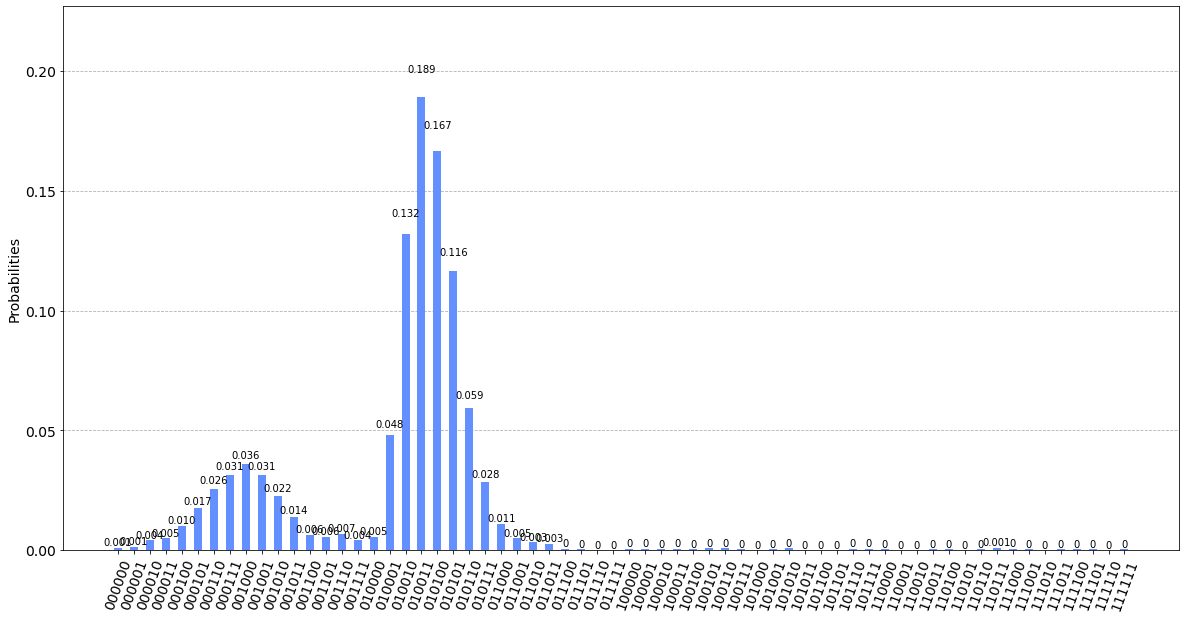

In [22]:
for a in range(N):
    s = bin(a)[2:]
    while len(s)!=6:
        s='0'+s
    if s not in answer.keys():
        answer[s] = 0
plot_histogram(answer, figsize = [20,10])

1.0000000000000002


/opt/conda/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


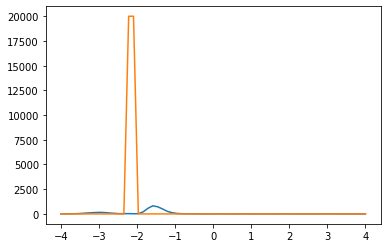

In [23]:
new_psi=np.zeros(N)
count=0
for key in sorted(answer.keys()):
  new_psi[count]=answer[key]
  count+=1
new_psi=new_psi/np.sqrt(np.sum(psi**2))
barrier=np.zeros(N)
barrier[14:16]=20000
print(np.sum(np.abs(psi**2)))
plt.plot(x,new_psi)
plt.plot(x,barrier)
plt.show()